In [27]:
import globus_sdk
import os, requests

## Globus client ID and portal ID
CLIENT_ID = "04dc20ba-d8e4-4a9a-9cc9-3ed3f3d49447" 
ENDPOINT_ID = "74defd5b-5f61-42fc-bcc4-834c9f376a4f"  # Your endpoint ID
INDEX_ID = "4428cfe6-611b-48db-81b2-167a7d9710ea"

app = globus_sdk.UserApp(
    app_name="Notebook Main App",
    client_id=CLIENT_ID)

search_client = globus_sdk.SearchClient(app=app)
transfer_client = globus_sdk.TransferClient(app=app)

https_scope = f"https://auth.globus.org/scopes/{ENDPOINT_ID}/https"
app.add_scope_requirements({"{COLLECTION_ID}": https_scope})

# Globus login
app.login()

token = app.get_authorizer(ENDPOINT_ID).access_token
print(token)


Please authenticate with Globus here:
-------------------------------------
https://auth.globus.org/v2/oauth2/authorize?client_id=04dc20ba-d8e4-4a9a-9cc9-3ed3f3d49447&redirect_uri=https%3A%2F%2Fauth.globus.org%2Fv2%2Fweb%2Fauth-code&scope=urn%3Aglobus%3Aauth%3Ascope%3Asearch.api.globus.org%3Asearch+https%3A%2F%2Fauth.globus.org%2Fscopes%2F74defd5b-5f61-42fc-bcc4-834c9f376a4f%2Fhttps+urn%3Aglobus%3Aauth%3Ascope%3Atransfer.api.globus.org%3Aall+openid&state=_default&response_type=code&code_challenge=el97ppE78VZhir6-iAawmGv7zifuEy_F7M9Fnr4jG_o&code_challenge_method=S256&access_type=online&prefill_named_grant=Notebook+Main+App+on+ripchip
-------------------------------------



AgYabEJmVpobDnPYq1w6Y6G8jbVGDXvm9bW7K776Jlv3JPMqmyfWCX2DxOPywp0vjkO5rnn5zy25gjC6wK0y8fK3o21


In [28]:

## Query function
def make_query(query, field_name='dc.identifiers.identifier', filter_value='*',  limit=10):
    
    query_data = {
        'q':query,
        'limit': limit,
        'advanced' : True,
        'filters' : [
            {
                "type": "like",
                "field_name": field_name,
                "value": filter_value
            }
        ]
    }
    print(query_data)
    response = search_client.post_search(
        index_id=INDEX_ID,
        data=query_data
        )
    print("Query results: " + str(response['total']))
    return response

def get_log_in_memory(log_file_url):
    response = requests.get(log_file_url, headers={'Authorization': f'Bearer {token}'})
    response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
    file_content_in_memory: bytes = response.content
    log_file_content = file_content_in_memory.decode('utf-8')
    # Decode bytes to string and print as text file
    return log_file_content

def get_result_file(result_file_url):
    import subprocess
    import os
    
    # Extract filename from URL
    filename = os.path.basename(result_file_url)
    
    # Use wget to download the file with authorization header
    wget_command = [
        'wget',
        '--header', f'Authorization: Bearer {token}',
        '-O', filename,  # Save to current directory with original filename
        result_file_url
    ]
    
    # Execute wget command
    subprocess.run(wget_command, check=True)
    
    # Return the local filename for reference
    return filename


In [29]:
D100_set = make_query(query = "milliron", filter_value='*D100*', limit=20)

{'q': 'milliron', 'limit': 20, 'advanced': True, 'filters': [{'type': 'like', 'field_name': 'dc.identifiers.identifier', 'value': '*D100*'}]}
Query results: 12


--2025-06-18 16:38:24--  https://g-f6125.fd635.8443.data.globus.org/XPCSDATA/Automate/2025-1/milliron202503/rigaku_qmap_Sq360_Dq36_Lin_0501/D0044_D100_a0050_f100000_t534C_r00003/D0044_D100_a0050_f100000_t534C_r00003_results.hdf
Resolving g-f6125.fd635.8443.data.globus.org (g-f6125.fd635.8443.data.globus.org)... 140.221.68.243, 140.221.68.244
Connecting to g-f6125.fd635.8443.data.globus.org (g-f6125.fd635.8443.data.globus.org)|140.221.68.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-hdf]
Saving to: ‘D0044_D100_a0050_f100000_t534C_r00003_results.hdf’

     0K .......... .......... .......... .......... .......... 13.4M
    50K .......... .......... .......... .......... .......... 26.0M
   100K .......... .......... .......... .......... .......... 38.1M
   150K .......... .......... .......... .......... .......... 48.9M
   200K .......... .......... .......... .......... .......... 82.0M
   250K .......... .......... ..........

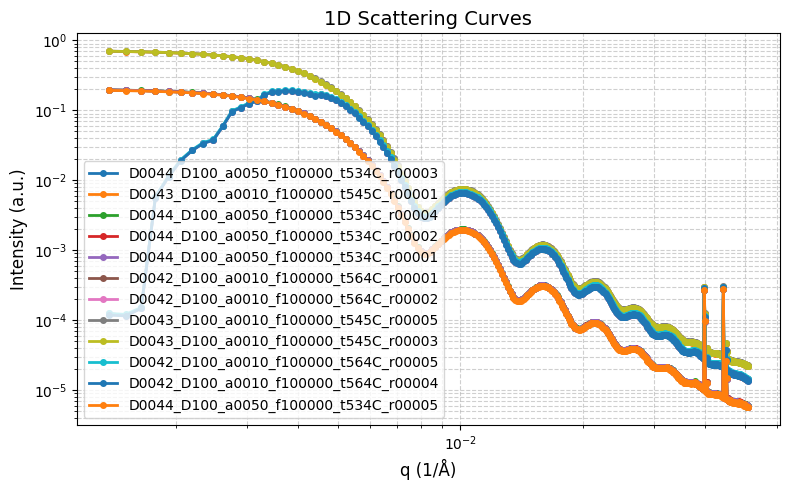

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [30]:
from nb_plot import start_new_plot, plot_hdf_overlay, show_plot
from metadata import parse_result_files

start_new_plot(title="1D Scattering Curves", logx=True, logy=True)
for qfile in D100_set["gmeta"]:
    result_file_url, _, _ = parse_result_files(qfile, local_path='https://g-f6125.fd635.8443.data.globus.org')
    result_file = get_result_file(result_file_url)
    plot_hdf_overlay(
        result_file, 
        x = '/xpcs/qmap/static_v_list_dim0', 
        y = '/xpcs/temporal_mean/scattering_1d',
        label = qfile['entries'][0]['content']['dc']['titles'][0]['title'])

show_plot()

In [31]:
import os
import glob

# Find all downloaded HDF result files
hdf_files = glob.glob("*_results.hdf")

# Remove each file
for file in hdf_files:
    try:
        os.remove(file)
        print(f"Removed: {file}")
    except OSError as e:
        print(f"Error removing {file}: {e}")

print(f"Cleaned up {len(hdf_files)} downloaded files")


Removed: D0044_D100_a0050_f100000_t534C_r00005_results.hdf
Removed: D0042_D100_a0010_f100000_t564C_r00005_results.hdf
Removed: D0044_D100_a0050_f100000_t534C_r00003_results.hdf
Removed: D0042_D100_a0010_f100000_t564C_r00002_results.hdf
Removed: D0044_D100_a0050_f100000_t534C_r00001_results.hdf
Removed: D0043_D100_a0010_f100000_t545C_r00001_results.hdf
Removed: D0043_D100_a0010_f100000_t545C_r00003_results.hdf
Removed: D0042_D100_a0010_f100000_t564C_r00001_results.hdf
Removed: D0043_D100_a0010_f100000_t545C_r00005_results.hdf
Removed: D0044_D100_a0050_f100000_t534C_r00004_results.hdf
Removed: D0044_D100_a0050_f100000_t534C_r00002_results.hdf
Removed: D0042_D100_a0010_f100000_t564C_r00004_results.hdf
Cleaned up 12 downloaded files
